In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import NoNorm
import math


In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)


def hough_line(img, angle_step=1, lines_are_white=True, value_threshold=5):
    """
    Hough transform for lines
    Input:
    img - 2D grayscale image - numpy ndarray
    angle_step - Spacing between angles to use every n-th angle
                 between -90 and 90 degrees. Default step is 1.
    lines_are_white - boolean indicating whether lines to be detected are white
    value_threshold - Pixel values above or below the value_threshold are edges
    Returns:
    accumulator - 2D array of the hough transform accumulator
    theta - array of angles used in computation, in radians.
    rhos - array of rho values. Max size is 2 times the diagonal
           distance of the input image.
    """
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(-90.0, 90.0, angle_step))
    width, height = img.shape
    diag_len = int(round(math.sqrt(width * width + height * height)))
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

    # bien dung lai
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # hough accumulator
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint8)
    # (row, col) indexes to edges
    are_edges = img > value_threshold if lines_are_white else img < value_threshold
    y_idxs, x_idxs = np.nonzero(are_edges)

    # vote 
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]

        for t_idx in range(num_thetas):
            # Calculate rho. diag_len is added for a positive index
            rho = diag_len + int(round(x * cos_t[t_idx] + y * sin_t[t_idx]))
            accumulator[rho, t_idx] += 1

    return accumulator, thetas, rhos


def show_hough_line(accumulator, thetas, rhos,):
    plt.imshow(accumulator, aspect='auto', cmap='jet', extent=[np.rad2deg(thetas[-1]), np.rad2deg(thetas[0]), rhos[-1], rhos[0]])
    plt.show()

def show_image(image, title="sample", figsize=(8,6), tickoff=False):
  plt.figure(figsize=figsize)
  if image.ndim == 2:
      plt.imshow(image, cmap="gray", norm=NoNorm())
  else:
      plt.imshow(image)
  plt.title(title)
  plt.show()

def show_double_image(image1,image2, title="Sample",figsize=(8,6)):
  fig, (ax1, ax2) = plt.subplots(1, 2,figsize=figsize)
  fig.suptitle(title)
  ax1.imshow(image1,cmap="gray", norm=NoNorm())
  ax2.imshow(image2,cmap="gray", norm=NoNorm())

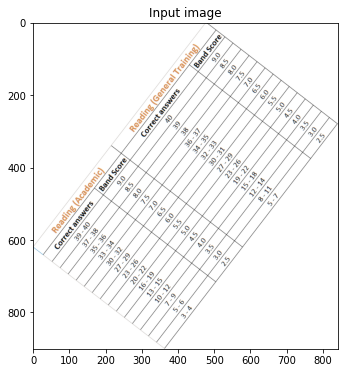

In [4]:
img = cv2.imread('./images/rotated_bangdiem.png', cv2.IMREAD_COLOR)
img_gray = rgb2gray(img)
show_image(img, "Input image")

- 24 phút (local machine, no gpu)

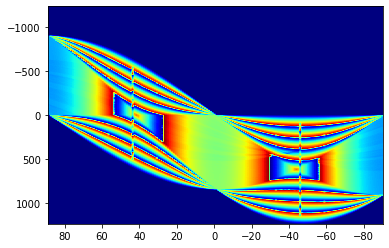

In [5]:
accumulator, thetas, rhos = hough_line(img_gray)
show_hough_line(accumulator,thetas, rhos)

- `Threshold means` in the accumulator how many votes needed to consider this (rho, theta) as a line.
- `minLineLength` might be the length of the line calculated from the points that voted for it. Meaning, if we have a 5 points to vote for a certain line and all these points are so close, then the lineLength will be short may be 5 pixels. On the other hand, if 3 points voted for another line and the points are far a part, then the lineLength is large may be 20 pixels.
- If the cells of accumulator are wide and there are many closely spaced short lines, then the count of accumulator would be high. The `min_line_length` would help solve such issues.
#### Canny parameter
- image: Source/Input image of n-dimensional array.
- threshold1: It is the High threshold value of intensity gradient.
- threshold2: It is the Low threshold value of intensity gradient.
- apertureSize: Order of Kernel(matrix) for the Sobel filter. Its default value is (3 x 3), and its value should be odd between 3 and 7. It is used for finding image gradients. Filter is used for smoothening and sharpening of an image.
- L2gradient: This specifies the equation for finding gradient magnitude. L2gradient is of boolean type, and its default value is False.

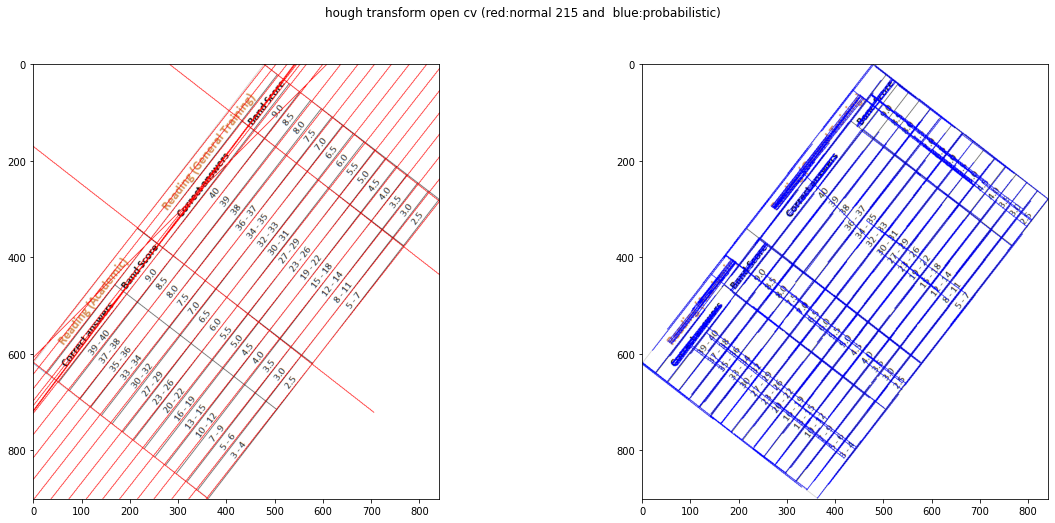

In [112]:
pic1 = np.copy(img)
pic2 = np.copy(img)
dst = cv2.Canny(img_gray, 50, 200,L2gradient=True)



lines200 = cv2.HoughLines(dst, 1, np.pi / 180, 200, None, 0, 0)
linesP = cv2.HoughLinesP(dst, 1, np.pi / 180, 80, None, 70, 10)

if lines200 is not None:
    for i in range(0, len(lines200)):
        rho = lines200[i][0][0]
        theta = lines200[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(pic1, pt1, pt2, (255,0,0), 1, cv2.LINE_4)


if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(pic2, (l[0], l[1]), (l[2], l[3]), (0,0,255), 1, cv2.LINE_4)
show_double_image(pic1, pic2, "hough transform open cv (red:normal 215 and  blue:probabilistic)",figsize=(20,8))

Ảnh được đánh dấu góc trước chứ không tự detect góc
Đã pad để khỏi mất cạnh

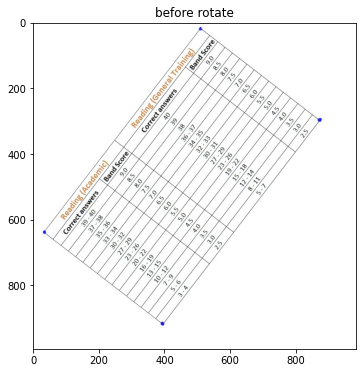

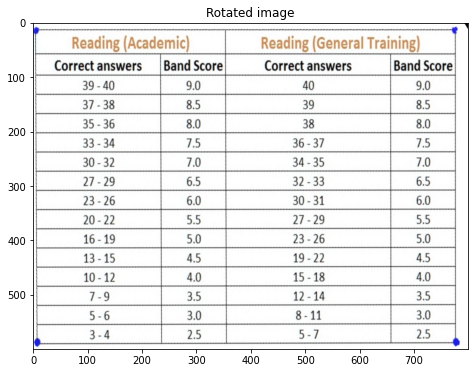

In [91]:
img_before_rotate = cv2.imread('./images/rotated_bangdiem_edged.png', cv2.IMREAD_COLOR)
lower_red = np.array([0, 0, 252])  # BGR-code of your lowest red
upper_red = np.array([226, 224, 255]) 
mask = cv2.inRange(img_before_rotate, lower_red, upper_red) 
# show_image(img_before_rotate, "mask") 
# #get all non zero values
coord=cv2.findNonZero(mask).reshape(-1,2)
accepted_length = 40
final_coord = [coord[0]]
for i in coord:
    add = True
    for j in final_coord:
        if np.linalg.norm(i-j) < accepted_length:
            add = False
    if add:
        final_coord.append(i)

h,w = 600,800

M = cv2.getPerspectiveTransform(np.float32([final_coord[2],final_coord[0],final_coord[3],final_coord[1]]),np.float32([[10,10],[w-20,10],[10,h-20],[w-20,h-20]]))
img_after_rotate = cv2.warpPerspective(img_before_rotate,M,(w,h))
show_image(img_before_rotate, "before rotate")
show_image(img_after_rotate, "Rotated image")

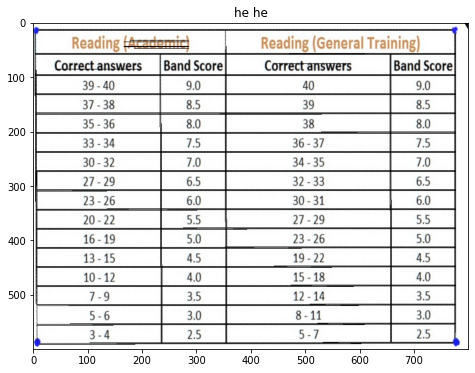

In [142]:
def line_highlight(img_after_rotate, lines_color=(0,0,255), value_threshold=80, min_length = 100, max_gap = 6):
    split = img_after_rotate.copy()
    cannied = cv2.Canny(rgb2gray(split), 70, 110,23,L2gradient=True)
    lines = cv2.HoughLinesP(cannied, 1, np.pi / 180, value_threshold, None, min_length, max_gap)
    if lines is not None:
        for i in range(0, len(lines)):
            l = lines[i][0]
            cv2.line(split, (l[0], l[1]), (l[2], l[3]), lines_color , 1, cv2.LINE_4)
    return split

highlighted_image = line_highlight(img_after_rotate, lines_color=(0,0,0))
show_image(highlighted_image, "he he")

[  0 232 353 661 782]
[  0  35  66  94 122 150 178 206 234 262 290 318 346 374 402 430 458]


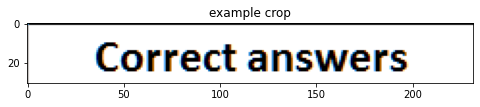

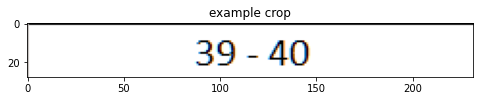

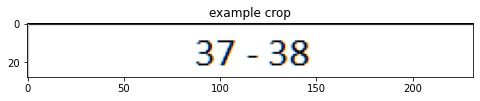

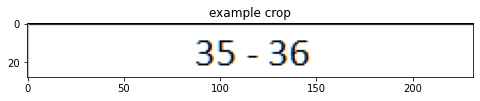

In [176]:

origin =cv2.imread('./images/bangdiem.png', cv2.IMREAD_COLOR)
grayed = cv2.cvtColor(origin, cv2.COLOR_BGR2GRAY)
# grayed =rgb2gray(highlighted_image)
# configure mask
grayed[grayed <= 250] = 1
grayed[grayed > 250] = 0
# show_image(grayed, "gray")

sum_col = np.sum(grayed, axis=0)
sum_row = np.sum(grayed, axis=1)
# cot thi phan loai hoi kho
col_index = np.where(sum_col > 0.92 * sum_col.max())[0]
row_index = np.where(sum_row > 0.9 * sum_row.max())[0]
print(col_index)
print(row_index)
for i in range(1,5):

    example_crop = origin[row_index[i]:row_index[i+1], col_index[0]:col_index[1]]
    show_image(example_crop, "example crop")